In [31]:
# %load pipeline.py
%matplotlib inline

import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.lines import Line2D
import glob
import random


SAVE_PATH = "vid_images_latest"
VIDEO_FILE = "./project_video.mp4"

#SAVE_PATH = "vid_images_short_1"
#VIDEO_FILE = "./project_video_short_1.mp4"

In [106]:
class Distortion (object):
    def __init__(self, _imgpath, _cornerSize):
        self.imgpath = _imgpath
        self.nx, self.ny = _cornerSize

        self.images = {}
        self.objpoints = []
        self.imgpoints = []
        self.gshape = None

        # load images
        self.loadImages()


    #------------------------------------------------------------
    # loadImages
    # load images
    #------------------------------------------------------------
    def loadImages(self):
        files = glob.glob(self.imgpath + "/*.jpg")
        for item in files:
            basef = item.split('/')[-1].split('.')[0]
            self.images[basef] = mpimg.imread(item)


    #------------------------------------------------------------
    # DEF preparePoints
    # collect imagepoints and objectpoints using provided images
    #------------------------------------------------------------
    def preparePoints(self):
        # initialize arrays
        self.objpoints = []
        self.imgpoints = []
        self.cornered_images = {}
        # define object points with corner size
        objp = np.zeros((self.ny*self.nx,3), np.float32)
        objp[:,:2] = np.mgrid[0:self.nx,0:self.ny].T.reshape(-1,2)

        # collect imgpoints and objpoints
        for key in self.images.keys():
            img = self.images[key]
            # convert RGB to gray
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # for later use in calibrate()
            if self.gshape is None:
                self.gshape = gray.shape[::-1]

            # find corners
            ret, corners = cv2.findChessboardCorners(gray, (self.nx,self.ny), None)

            if ret:
                # add image points and object points
                self.imgpoints.append(corners)
                self.objpoints.append(objp)

                # draw corners and append to cornered_images
                self.cornered_images[key] = cv2.drawChessboardCorners(img.copy(), (self.nx, self.ny), corners, ret)


    #------------------------------------------------------------
    # DEF calibrate()
    # calculate camera matrix and distortion coefficients
    #------------------------------------------------------------
    def calibrate(self, _fromFile=False):
        if _fromFile:
            dist_pickle = pickle.load( open( "dist_pts.p", "rb" ) )
            self.objpoints = dist_pickle["objpoints"]
            self.imgpoints = dist_pickle["imgpoints"]
            self.gshape = dist_pickle["gshape"]


        else:
            # prepare imgpoints and objpoints
            self.preparePoints()

            # optional: save points to pickle file for later use
            dist_pickle = { "objpoints": self.objpoints, "imgpoints": self.imgpoints, \
                            "gshape": self.gshape}
            with open("dist_pts.p", 'wb') as fp:
                pickle.dump(dist_pickle, fp, protocol=pickle.HIGHEST_PROTOCOL)
            fp.close()


        # get calibrate coefficients
        ret, self.mtx, self.dist, rvecs, tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, self.gshape[::-1], None, None)


    #------------------------------------------------------------
    # DEF undistort()
    # undistort images
    #------------------------------------------------------------
    def undistort(self, _testImg=None):
        if _testImg is not None:    # perform distort-correction on provided image
            return cv2.undistort(_testImg, self.mtx, self.dist, None, self.mtx)
        else:   # perform distort-correction on chessboard images
            self.undistorted_images = {}
            for key in self.images.keys():
                img = self.images[key]
                # undistort image
                self.undistorted_images[key] = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)


    #------------------------------------------------------------
    # DEF showSampleResult()
    # show a sample cornered image and undistorted image
    #------------------------------------------------------------
    def showSampleResult(self):
        # pick a random sample
        key = self.pickRandomKey()
        # original image
        img = self.images[key]
        # cornered image
        cimg = self.cornered_images[key]
        # undistorted image
        udimg = self.undistorted_images[key]

        # plot
        plt.ion()
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 5))
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=14)
        ax2.imshow(cimg)
        ax2.set_title('Corners on Image', fontsize=14)
        ax3.imshow(udimg)
        ax3.set_title('Undistorted Image', fontsize=14)

        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        input("Showing a sample result![Enter]")

        plt.ioff()

        # save images
        mpimg.imsave("./output_images/" + key + "_cornered.jpg", cimg)
        mpimg.imsave("./output_images/" + key + "_undistorted.jpg", udimg)
        plt.savefig("./output_images/" + key + "_fig.jpg")


    #------------------------------------------------------------
    # DEF pickRandomKey()
    # pick a random key
    #------------------------------------------------------------
    def pickRandomKey(self):
        random.seed()
        keys = sorted(self.cornered_images.keys())

        idx = random.randint(0, len(keys)-1)
        return keys[idx]


    

class Threshold (object):
    def __init__(self, _sobel_kernel):
        self.ksize = _sobel_kernel
        self.img = None
        self.gray = None


    #------------------------------------------------------------
    # DEF readImage()
    # load image from file and make grayscale
    #------------------------------------------------------------
    def readImage(self, _imgf):
        self.img = mpimg.imread(_imgf)
        self.gray = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        self.hls = cv2.cvtColor(self.img, cv2.COLOR_BGR2HLS)


    #------------------------------------------------------------
    # DEF setImage()
    # if already loaded from file, just copy the buf to the class object
    #------------------------------------------------------------
    def setImage(self, _imgbuf):
        self.img = _imgbuf
        self.gray = cv2.equalizeHist(cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY))
        self.hls = cv2.cvtColor(self.img, cv2.COLOR_BGR2HLS)


    #------------------------------------------------------------
    # DEF gray_thresh()
    # thresholding in grayscale
    #------------------------------------------------------------
    def gray_thresh(self, thresh):
        binary = np.zeros_like(self.gray)
        binary[(self.gray > thresh[0]) & (self.gray <= thresh[1])] = 1

        return binary


    #------------------------------------------------------------
    # DEF saturation_thresh()
    # thresholding in HLS space with S channel
    #------------------------------------------------------------
    def saturation_thresh(self, thresh=(0, 255)):
        H = self.hls[:,:,0]
        L = self.hls[:,:,1]
        S = self.hls[:,:,2]

        binary = np.zeros_like(S)
        binary[(S > thresh[0]) & (S <= thresh[1])] = 1

        return binary


    #------------------------------------------------------------
    # DEF setSobelKernel()
    # in case would like to change the kernel size
    #------------------------------------------------------------
    def setSobelKernel(self, _sobel_kernel):
        self.ksize = _sobel_kernel


    #------------------------------------------------------------
    # DEF abs_sobel_thresh()
    # Calculate directional gradient using Sobel() operator and apply threshold
    #------------------------------------------------------------
    def abs_sobel_thresh(self, orient='x', thresh=(0, 255)):
        # Apply x or y gradient with the OpenCV Sobel() function
        if orient == 'x':
            sobel = cv2.Sobel(self.gray, cv2.CV_64F, 1, 0, ksize=self.ksize)
        elif orient == 'y':
            sobel = cv2.Sobel(self.gray, cv2.CV_64F, 0, 1, ksize=self.ksize)

        # take the absolute value
        abs_sobel = np.absolute(sobel)

        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

        # Apply threshold
        grad_binary = np.zeros_like(scaled_sobel)
        grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

        return grad_binary


    #------------------------------------------------------------
    # DEF mag_thresh()
    # Calculate gradient magnitude and apply threshold
    #------------------------------------------------------------
    def mag_thresh(self, thresh=(0, 255)):
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(self.gray, cv2.CV_64F, 1, 0, ksize=self.ksize)
        sobely = cv2.Sobel(self.gray, cv2.CV_64F, 0, 1, ksize=self.ksize)

        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)

        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255
        gradmag = (gradmag/scale_factor).astype(np.uint8)

        # Apply threshold
        mag_binary = np.zeros_like(gradmag)
        mag_binary [(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

        return mag_binary


    #------------------------------------------------------------
    # DEF dir_thresh()
    # Calculate direction of the gradient and apply threshold
    #------------------------------------------------------------
    def dir_thresh(self, thresh=(0, np.pi/2)):
        # Calculate the x and y gradients
        sobelx = cv2.Sobel(self.gray, cv2.CV_64F, 1, 0, ksize=self.ksize)
        sobely = cv2.Sobel(self.gray, cv2.CV_64F, 0, 1, ksize=self.ksize)

        # Take the absolute value of the gradient direction,
        # apply a threshold, and create a binary image result
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        dir_binary =  np.zeros_like(absgraddir)
        dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

        return dir_binary


    #------------------------------------------------------------
    # DEF run()
    # Run experiments!
    #------------------------------------------------------------
    def run(self, _colorthresh=(180,255), _sthresh=(0, 255),
                  _gxthresh=(30, 100), _gythresh=(30, 100),
                  _mthresh=(30, 100), _dthresh=(0.7, 1.3)):
        # Apply each of the thresholding functions
        self.g_binary = self.gray_thresh(_colorthresh)
        self.s_binary = self.saturation_thresh(_sthresh)

        self.gradx = self.abs_sobel_thresh(orient='x', thresh=_gxthresh)
        self.grady = self.abs_sobel_thresh(orient='y', thresh=_gythresh)
        self.mag_binary = self.mag_thresh(thresh=_mthresh)
        self.dir_binary = self.dir_thresh(thresh=_dthresh)

        s_bin_flatten = np.asarray(self.s_binary).flatten()
        s_binary_true = [i for i, x in enumerate(s_bin_flatten) if (x==1 and i > len(s_bin_flatten)*.5)]
        rat = float(len(s_binary_true) / s_bin_flatten.shape[0])
        if rat > 0.1:
            indices =   ((self.s_binary == 1) & (self.dir_binary == 1) | 
                         (self.g_binary == 1) & (self.dir_binary == 1) |
                         (((self.gradx == 1) | (self.grady == 1))))

        elif rat > 0.03:
            indices =  ((self.s_binary == 1) & (self.g_binary == 1) |
                        (((self.gradx == 1) & (self.grady == 1)) | (self.mag_binary == 1)))
        else:
            indices =  ((self.s_binary == 1) |
                        (((self.gradx == 1) & (self.grady == 1)) | (self.mag_binary == 1)))

        self.combined = np.zeros_like(self.dir_binary)
        self.combined[indices] = 1
    

    #------------------------------------------------------------
    # DEF visualize()
    # Visuzlize experiment results
    #------------------------------------------------------------
    def visualize(self):
        plt.ion()
        # Plot the result
        f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(9, 14))
        f.tight_layout()
        ax1.imshow(self.img)
        ax1.set_title('Original Image', fontsize=12)

        ax2.imshow(self.g_binary, cmap='gray')
        ax2.set_title('gray_binary', fontsize=12)

        ax3.imshow(self.s_binary, cmap='gray')
        ax3.set_title('S_binary', fontsize=12)

        ax4.imshow(self.gradx, cmap='gray')
        ax4.set_title('gradx', fontsize=12)

        ax5.imshow(self.grady, cmap='gray')
        ax5.set_title('grady', fontsize=12)

        ax6.imshow(self.mag_binary, cmap='gray')
        ax6.set_title('mag_binary', fontsize=12)

        ax7.imshow(self.dir_binary, cmap='gray')
        ax7.set_title('dir_binary', fontsize=12)

        ax8.imshow(self.combined, cmap='gray')
        ax8.set_title('combined', fontsize=12)

        plt.subplots_adjust(left=0., right=1, top=0.99, bottom=0.)
        plt.tight_layout()
        #input("showing sample results![Enter]")
        plt.ioff()

        #plt.savefig("./output_images/thresholded_binaries_fig.jpg")


class Warp(object):
    def __init__(self, _img, _isgray=False):
        self.img = _img
        self.imsize = (self.img.shape[1], self.img.shape[0])
        self.isgray = _isgray


    #------------------------------------------------------------
    # DEF setImage()
    # in case to change image
    #------------------------------------------------------------
    def setImage(self, _img, _isgray=False):
        self.img = _img
        self.imsize = (self.img.shape[1], self.img.shape[0])
        self.isgray = _isgray


    #------------------------------------------------------------
    # DEF setPoints()
    # set src points and destination points
    #------------------------------------------------------------
    def setPoints(self):
        offset = 100
        x, y = self.imsize
        cx, cy = x/2, y/2
        self.src = np.float32([ [(cx - offset/2 - 20), cy + offset],
                                [(x / 6) - 10, y],
                                [(x * 5 / 6 + offset), y],
                                [(cx + offset/2 + 40), cy + offset]    ])

        self.dst = np.float32([ [(x / 4), 0],
                                [(x / 4), y],
                                [(x * 3 / 4), y],
                                [(x * 3 / 4), 0]    ])


    #------------------------------------------------------------
    # DEF warp()
    # warp image and return top-down view
    #------------------------------------------------------------
    def warp(self):
        # get transform matrix M
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)

        # get Minv
        self.Minv = cv2.getPerspectiveTransform(self.dst, self.src)
        # warp image to a top-down view
        self.warped = cv2.warpPerspective(self.img, self.M, self.imsize)


    #------------------------------------------------------------
    # DEF visualize()
    # Visuzlize results
    #------------------------------------------------------------
    def visualize(self, _savef):
        plt.ion()
        # Plot the result
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 8))
        f.tight_layout()

        if self.isgray:
            ax1.imshow(self.img, cmap='gray')
        else:
            ax1.imshow(self.img)
        ax1.set_title('Original Image', fontsize=12)

        l = self.getLines(_src=True)
        ax1.add_line(l)

        if self.isgray:
            ax2.imshow(self.warped, cmap='gray')
        else:
            ax2.imshow(self.warped)

        ax2.set_title('Undistorted and Warped Image', fontsize=12)
        l = self.getLines(_src=False)
        ax2.add_line(l)

        plt.subplots_adjust(left=0., right=1, top=0.96, bottom=0.)

        input("showing perceptively transformed result![Enter]")
        plt.ioff()

        plt.savefig(_savef)


    #------------------------------------------------------------
    # DEF getLines()
    # get lines with points
    #------------------------------------------------------------
    def getLines(self, _src=True):
        if _src:    # from self.src
            coords = self.src
        else:       # from self.dst
            coords = self.dst

        x = [item[0] for item in coords]
        y = [item[1] for item in coords]
        xs = [x[0], x[1], x[1], x[2], x[2], x[3], x[3], x[0]]
        ys = [y[0], y[1], y[1], y[2], y[2], y[3], y[3], y[0]]
        return Line2D(xs, ys, linewidth=3, color='red')


# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None



class Polynomial(object):
    def __init__(self, _bwimg, _wimg):
        # binary warped image
        self.bwImg = _bwimg
        self.wImg = _wimg

    def setNewImage(self, _new_bwimg, _new_wimg):
        self.bwImg = _new_bwimg
        self.wImg = _new_wimg

    def slideNfitPolynomial(self):
        # Take a histogram of the bottom half of the image
        self.histogram = np.sum(self.bwImg[int(self.bwImg.shape[0]/2):,:], axis=0)

        # Create an output image to draw on and visualize the result
        self.out_img = np.dstack((self.bwImg, self.bwImg, self.bwImg))*255

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(self.histogram.shape[0]/2)
        leftx_base = np.argmax(self.histogram[:midpoint])
        rightx_base = np.argmax(self.histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(self.bwImg.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = self.bwImg.nonzero()
        self.nonzeroy = np.array(nonzero[0])
        self.nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        self.margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 150
        # Create empty lists to receive left and right lane pixel indices
        self.left_lane_inds = []
        self.right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = self.bwImg.shape[0] - (window+1)*window_height
            win_y_high = self.bwImg.shape[0] - window*window_height
            win_xleft_low = leftx_current - self.margin
            win_xleft_high = leftx_current + self.margin
            win_xright_low = rightx_current - self.margin
            win_xright_high = rightx_current + self.margin

            # Draw the windows on the visualization image
            cv2.rectangle(self.out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
            cv2.rectangle(self.out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((self.nonzeroy >= win_y_low) & (self.nonzeroy < win_y_high) & (self.nonzerox >= win_xleft_low) & (self.nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((self.nonzeroy >= win_y_low) & (self.nonzeroy < win_y_high) & (self.nonzerox >= win_xright_low) & (self.nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            self.left_lane_inds.append(good_left_inds)
            self.right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(self.nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:
                rightx_current = np.int(np.mean(self.nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        self.left_lane_inds = np.concatenate(self.left_lane_inds)
        self.right_lane_inds = np.concatenate(self.right_lane_inds)

        # Extract left and right line pixel positions
        leftx = self.nonzerox[self.left_lane_inds]
        lefty = self.nonzeroy[self.left_lane_inds]
        rightx = self.nonzerox[self.right_lane_inds]
        righty = self.nonzeroy[self.right_lane_inds]

        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)


    def visualize(self):
        # Generate x and y values for plotting
        ploty = np.linspace(0, self.bwImg.shape[0]-1, self.bwImg.shape[0] )
        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]

        self.out_img[self.nonzeroy[self.left_lane_inds], self.nonzerox[self.left_lane_inds]] = [255, 0, 0]
        self.out_img[self.nonzeroy[self.right_lane_inds], self.nonzerox[self.right_lane_inds]] = [0, 0, 255]

        plt.ion()
        plt.imshow(self.out_img.astype(np.uint8))
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

        #input("showing polynomial fitting in a sliding window fashion![Enter]")
        plt.ioff()
        plt.savefig("./output_images/fitting_fig.jpg")


    def fit_next(self, _new_bwimg, _new_wimg):
        self.bwImg = _new_bwimg
        self.wImg = _new_wimg

        nonzero = self.bwImg.nonzero()
        self.nonzeroy = np.array(nonzero[0])
        self.nonzerox = np.array(nonzero[1])
        #self.margin = 100
        self.left_lane_inds = ((self.nonzerox > (self.left_fit[0]*(self.nonzeroy**2) + self.left_fit[1]*self.nonzeroy + self.left_fit[2] - self.margin)) & (self.nonzerox < (self.left_fit[0]*(self.nonzeroy**2) + self.left_fit[1]*self.nonzeroy + self.left_fit[2] + self.margin)))
        self.right_lane_inds = ((self.nonzerox > (self.right_fit[0]*(self.nonzeroy**2) + self.right_fit[1]*self.nonzeroy + self.right_fit[2] - self.margin)) & (self.nonzerox < (self.right_fit[0]*(self.nonzeroy**2) + self.right_fit[1]*self.nonzeroy + self.right_fit[2] + self.margin)))

        # Again, extract left and right line pixel positions
        leftx = self.nonzerox[self.left_lane_inds]
        lefty = self.nonzeroy[self.left_lane_inds]
        rightx = self.nonzerox[self.right_lane_inds]
        righty = self.nonzeroy[self.right_lane_inds]

        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)



    def visualize_next(self):
        # Generate x and y values for plotting
        ploty = np.linspace(0, self.bwImg.shape[0]-1, self.bwImg.shape[0] )
        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]

        # Create an image to draw on and an image to show the selection window
        self.out_img = np.dstack((self.bwImg, self.bwImg, self.bwImg))*255
        window_img = np.zeros_like(self.out_img)
        # Color in left and right line pixels
        self.out_img[self.nonzeroy[self.left_lane_inds], self.nonzerox[self.left_lane_inds]] = [255, 0, 0]
        self.out_img[self.nonzeroy[self.right_lane_inds], self.nonzerox[self.right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-self.margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+self.margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-self.margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+self.margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(self.out_img, 1, window_img, 0.3, 0)

        plt.ion()
        plt.clf()
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        #input("showing polynomial fitting for the next frame![Enter]")
        plt.ioff()

        plt.savefig("./output_images/fitting_next_fig.jpg")


    def measureCurvature_and_mapLane(self, _img, _Minv, _save=True):
        ploty = np.linspace(0, self.bwImg.shape[0]-1, self.bwImg.shape[0] )
        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]

        # Define y-value where we want radius of curvature as the maximum y-value,
        # corresponding to the bottom of the image
        y_eval = np.max(ploty)

        left_curverad = ((1 + (2*self.left_fit[0]*y_eval + self.left_fit[1])**2)**1.5) / np.absolute(2*self.left_fit[0])
        right_curverad = ((1 + (2*self.right_fit[0]*y_eval + self.right_fit[1])**2)**1.5) / np.absolute(2*self.right_fit[0])
        #print(left_curverad, right_curverad)

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Again, extract left and right line pixel positions
        leftx = self.nonzerox[self.left_lane_inds]
        lefty = self.nonzeroy[self.left_lane_inds]
        rightx = self.nonzerox[self.right_lane_inds]
        righty = self.nonzeroy[self.right_lane_inds]

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

        # Now our radius of curvature is in meters
        print("%.3fm, %.3fm"%(left_curverad, right_curverad))

        # Calculate the position of the vehicle with respect to center
        # assuming the camera is mounted at the center of the car
        midpt = (np.min(leftx) + np.max(rightx)) / 2
        mid_offset = midpt - self.bwImg.shape[1]/2
        mid_offset_m = xm_per_pix*mid_offset
        #print("mid_offset:", mid_offset)
        #print("mid_offset: %.3fm"%mid_offset_m)

        # Now, let's map it to the original image!

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(self.bwImg).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, _Minv, (self.wImg.shape[1], self.wImg.shape[0]))
        # Combine the result with the original image
        result = cv2.addWeighted(_img, 1, newwarp, 0.3, 0)

        # put some information
        text = "Radius of Curvature: %.3fm "%((left_curverad+right_curverad)/2)
        side = "left"
        if mid_offset_m < 0.0:  side = "right"
        text2 = "Vehicle is %.3fm %s of center"%(np.absolute(mid_offset_m), side)
        cv2.putText(result, text, (30,50), cv2.FONT_HERSHEY_DUPLEX, 1.2, (255, 255, 255), 2)
        cv2.putText(result, text2, (30,90), cv2.FONT_HERSHEY_DUPLEX, 1.2, (255, 255, 255), 2)

        if _save:
            plt.ion()
            plt.imshow(result)
            #input("showing final image!![Enter]")
            plt.ioff()
            mpimg.imsave("./output_images/final_mapped.jpg", result)
        else:
            plt.imshow(result)
            return result







In [107]:
class VideoLaneDetection(object):
    def __init__(self, _DT, _vidfile="./project_video.mp4"):
        self.DT = _DT
        self.videof = _vidfile

        self.TH = Threshold(_sobel_kernel=3)
        self.WP = None
        self.PN = None


    def run(self):
        vidcap = cv2.VideoCapture(self.videof)
        success,image = vidcap.read()
        count = 0
        success = True
        PNv = None
        FIRST_FRAME = True
        while success:
            success, frame = vidcap.read()
            print("[IDX: %d] Read a new frame: "%count, success)
            if not success:
                break

            plt.ion()

            # process image
            image = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

            # 1. undistort
            undist = self.DT.undistort(image)

            # 2. thresholding
            self.TH.setImage(undist)
            self.TH.run(_colorthresh=(82,220), _sthresh=(68, 252), 
                        _gxthresh=(18, 123), _gythresh=(50, 166), 
                        _mthresh=(102, 194), _dthresh=(0.3, 0.4))

            # 3. warp   
            # prepare warp_orig
            if FIRST_FRAME:  # initial run
                self.WP = Warp(undist)
                self.WP.setPoints()
                self.WP.warp()
                warped_orig = self.WP.warped.copy()
            else:
                self.WP.setImage(undist)
                self.WP.warp()
                warped_orig = self.WP.warped.copy()
                
            # prepare warp_binary
            self.WP.setImage(self.TH.combined, _isgray=True)
            self.WP.warp()
            Minv = self.WP.Minv
            warped_binary = self.WP.warped.copy()

            # 4. land line detection
            if FIRST_FRAME:  # initial run
                self.PN = Polynomial(_bwimg=warped_binary, _wimg=warped_orig)
                self.PN.slideNfitPolynomial()
            else:
                #self.PN.fit_next(_new_bwimg=warped_binary, _new_wimg=warped_orig)
                self.PN.setNewImage(_new_bwimg=warped_binary, _new_wimg=warped_orig)
                self.PN.slideNfitPolynomial()

            # 5. measure curvature, find vehicle position, and map lanes
            final_img = self.PN.measureCurvature_and_mapLane(_img=undist, _Minv=Minv, _save=False)

            # save to folder
            mpimg.imsave("./%s/frame_%05d.jpg"%(SAVE_PATH, count), final_img)     # save frame as JPEG file
            #mpimg.imsave("./%s/frame_%05d-orig.jpg"%(SAVE_PATH, count), image)     # save frame as JPEG file
            count += 1
            FIRST_FRAME = False

            # debug
            #input("process next?[Enter]")

In [108]:
#------------------------------------------------------------
# STEP 1. CAMERA CALIBRATION
# create Distortion object with calibration images and corner size
#------------------------------------------------------------
DT = Distortion('./camera_cal', (9, 6))
DT.calibrate(_fromFile=True)
DT.undistort()
DT.showSampleResult()

In [109]:

#------------------------------------------------------------
# STEP 2. APPLY ON A TEST image
#------------------------------------------------------------
test_img = mpimg.imread("./test_images/test2.jpg")
test_img_undist = DT.undistort(test_img)
mpimg.imsave("./output_images/test2_undistorted.jpg", test_img_undist)


rat:  0.02800347222222222


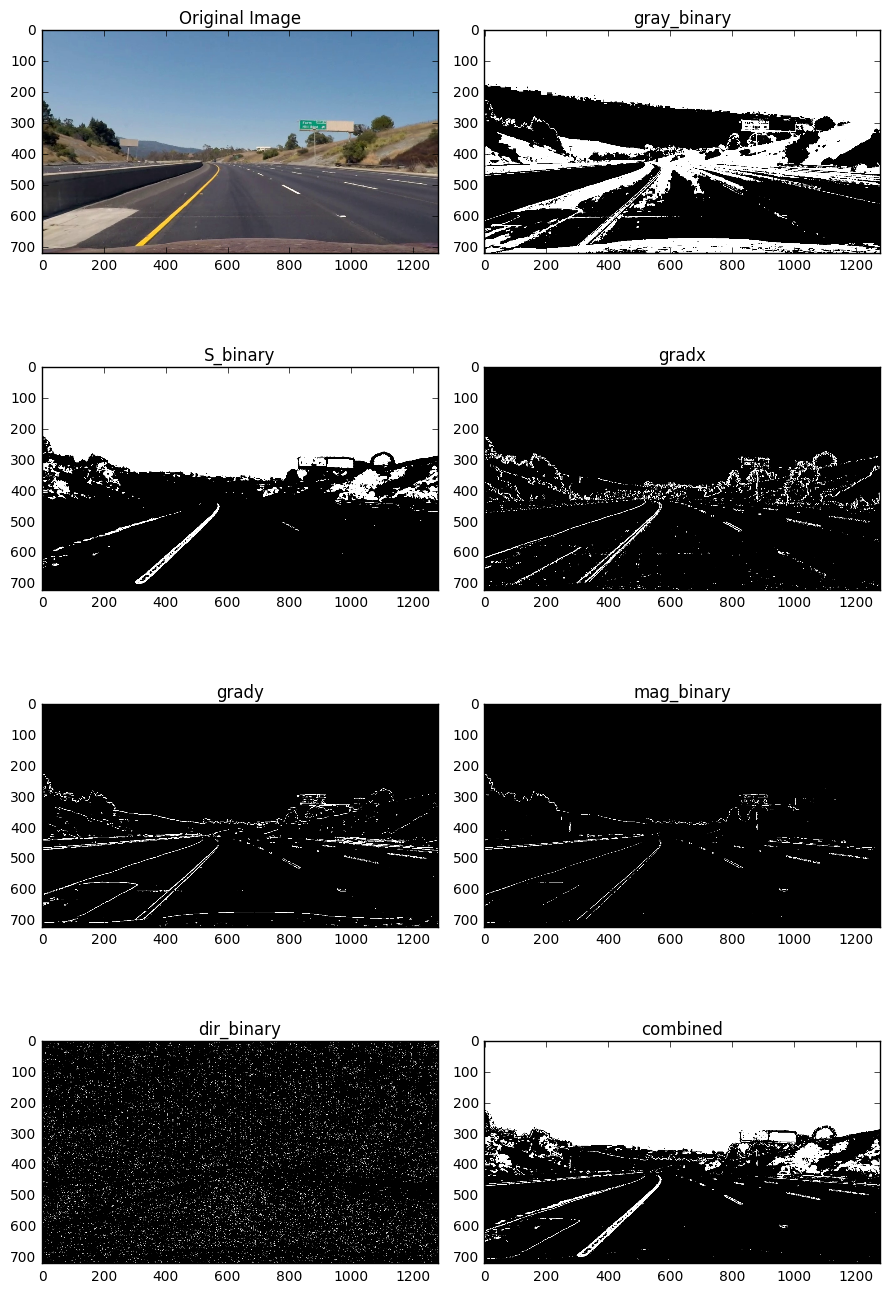

In [110]:
#------------------------------------------------------------
# STEP 3. GENERATE THRESHOLDED BINARY IMAGE
#------------------------------------------------------------
TH = Threshold(_sobel_kernel=3)
TH.setImage(test_img_undist)
#TH.run(_colorthresh=(82,220), _sthresh=(58, 252), 
#       _gxthresh=(45, 153), _gythresh=(49, 248), 
#       _mthresh=(31, 194), _dthresh=(0.3, 0.8))
#TH.visualize()


from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display

def interactive_mask(col_low=82, col_high=220, sat_low=68, sat_high=252, 
                     gx_low=18, gx_high=123, gy_low=50, gy_high=166, 
                     mag_low=102, mag_high=194, dir_low=0.3, dir_high=0.4):
    TH.run(_colorthresh=(col_low, col_high), _sthresh=(sat_low, sat_high), 
           _gxthresh=(gx_low, gx_high), _gythresh=(gy_low, gy_high), 
           _mthresh=(mag_low, mag_high), _dthresh=(dir_low, dir_high))

       
    s_bin_flatten = np.asarray(TH.s_binary).flatten()
    s_binary_true = [i for i, x in enumerate(s_bin_flatten) if (x==1 and i > len(s_bin_flatten)*.5)]
    rat = float(len(s_binary_true) / s_bin_flatten.shape[0])
    print("rat: ", rat)
    if rat > 0.3:
        indices = ((TH.s_binary == 1) & (TH.dir_binary == 1) | (TH.g_binary == 1) & (TH.dir_binary == 1) |
                    (((TH.gradx == 1) | (TH.grady == 1))))
    else:
        indices =  ((TH.s_binary == 1) & (TH.g_binary == 1) | (((TH.gradx == 1) & (TH.grady == 1)) |
                    (TH.mag_binary == 1)))
                    
    TH.combined = np.zeros_like(TH.dir_binary)
    TH.combined[indices] = 1
    TH.visualize()

if True: # ONLY FOR DEBUGGING
    interact(interactive_mask, col_low=(0, 255), col_high=(0,255), sat_low=(0,255), sat_high=(0,255),\
             gx_low=(0,255), gx_high=(0,255), gy_low=(0,255), gy_high=(0,255),\
             mag_low=(0,255), mag_high=(0,255), dir_low=(0, np.pi/2), dir_high=(0, np.pi/2))



src:  [[  570.           460.        ]
 [  203.33332825   720.        ]
 [ 1166.66662598   720.        ]
 [  730.           460.        ]]
dst:  [[ 320.    0.]
 [ 320.  720.]
 [ 960.  720.]
 [ 960.    0.]]


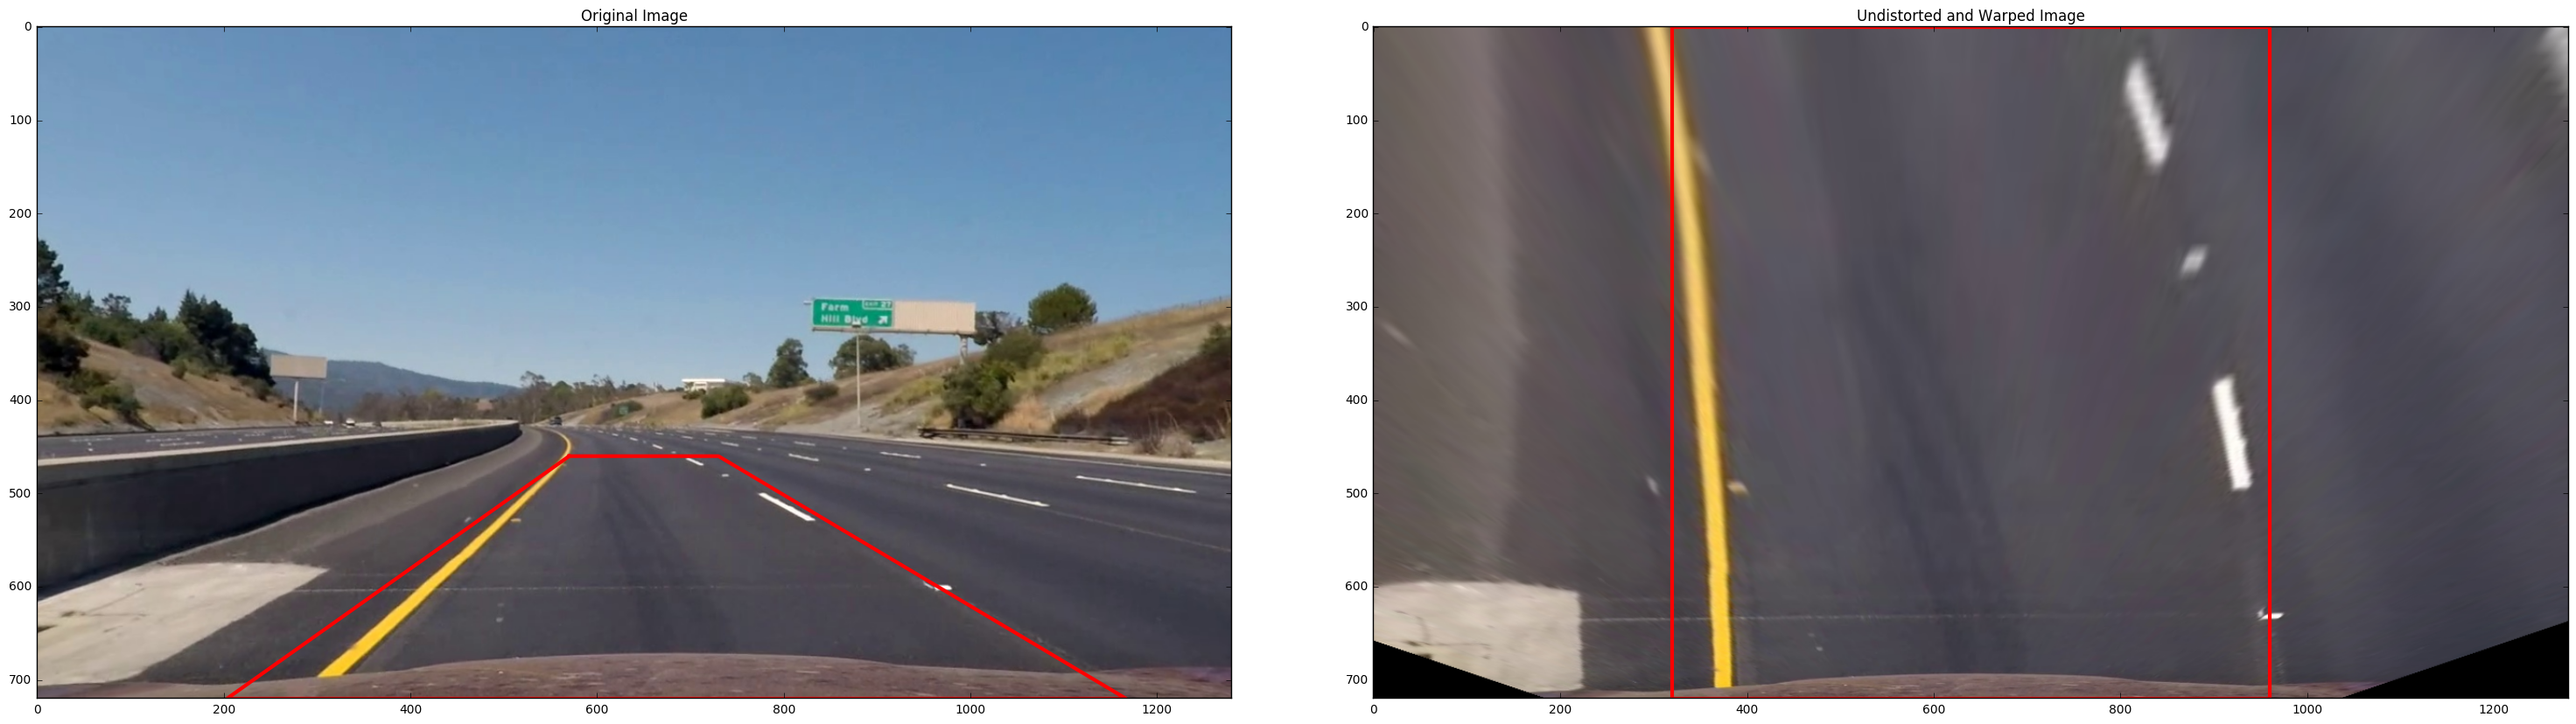

In [111]:
    #------------------------------------------------------------
    # STEP 4. PERSPECTIVE TRANSFORM
    #------------------------------------------------------------
    WP = Warp(test_img_undist)
    WP.setPoints()
    WP.warp()
    WP.visualize(_savef="./output_images/perceptive_transform_fig.jpg")
    warped_orig = WP.warped


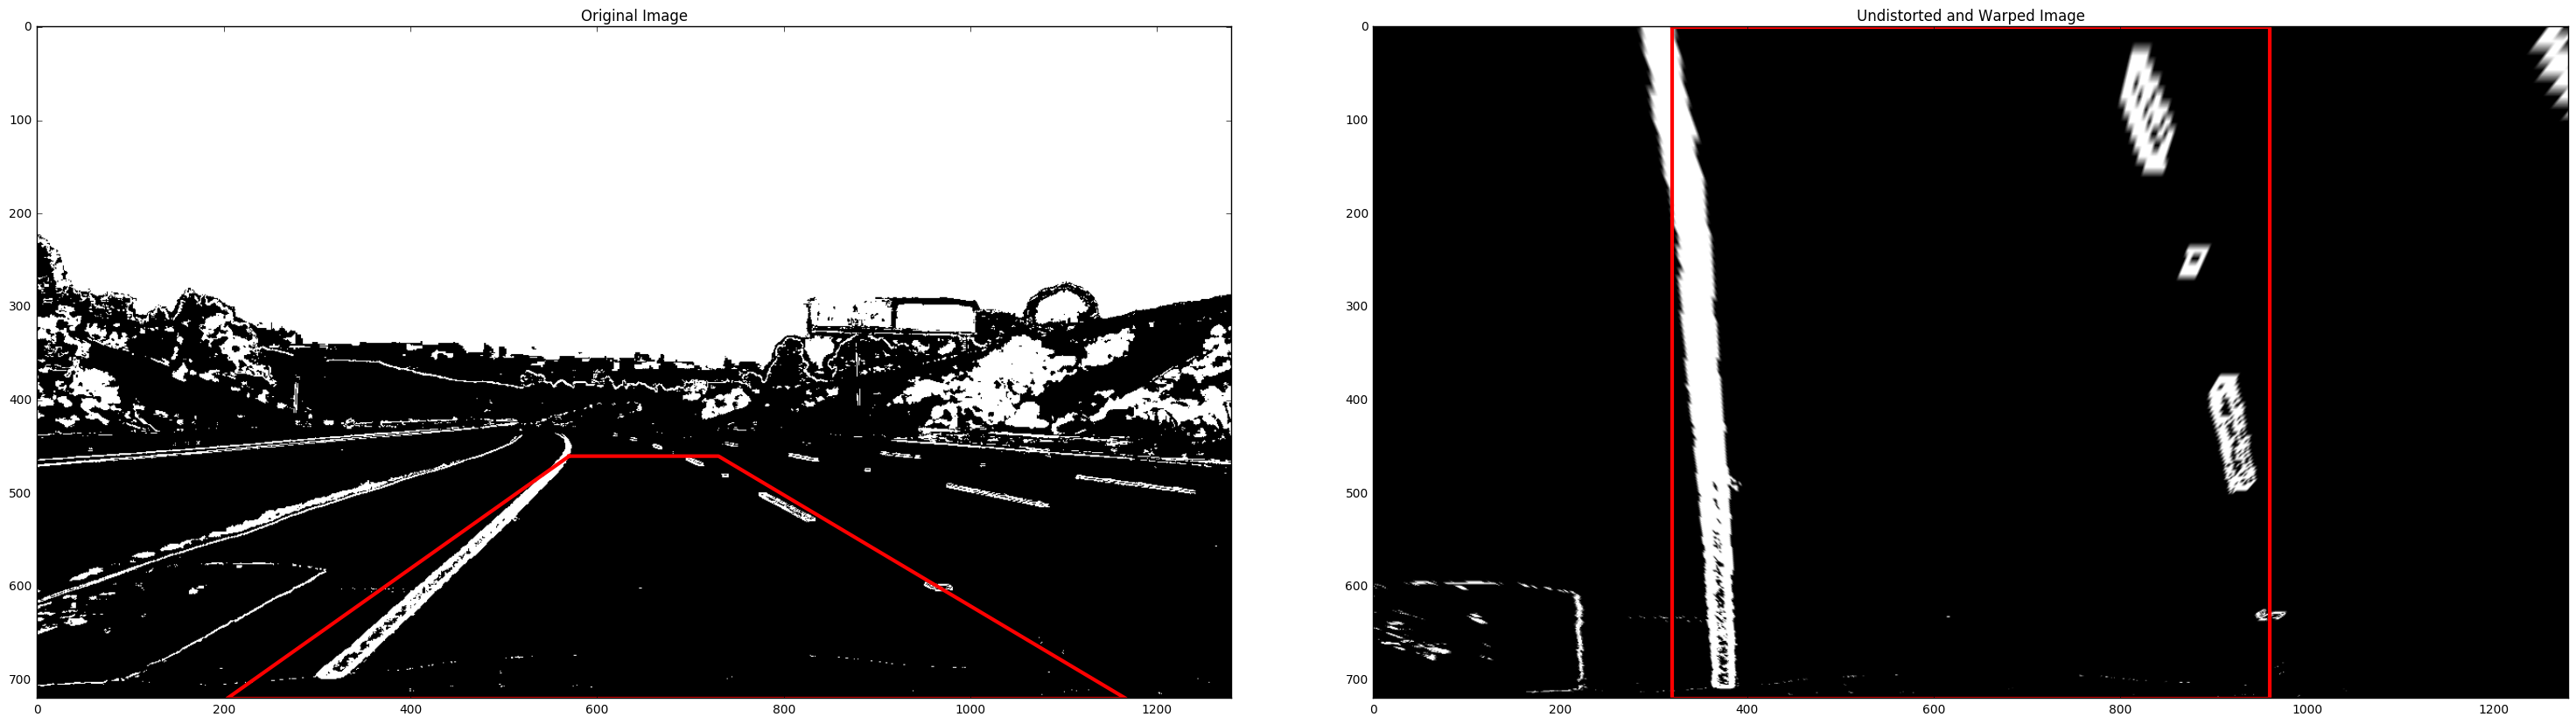

In [112]:
#------------------------------------------------------------
# STEP 5. LOCATE LANE LINES & FIT A POLYNOMIAL
#------------------------------------------------------------
WP.setImage(TH.combined, _isgray=True)
WP.warp()
WP.visualize(_savef="./output_images/perceptive_transform_fig2.jpg")




midpoint:  640
leftx_base: 363


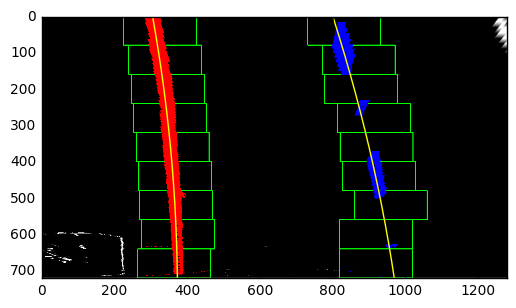

In [113]:
warped_binary = WP.warped
PN = Polynomial(_bwimg=warped_binary, _wimg=warped_orig)
PN.slideNfitPolynomial()
PN.visualize()


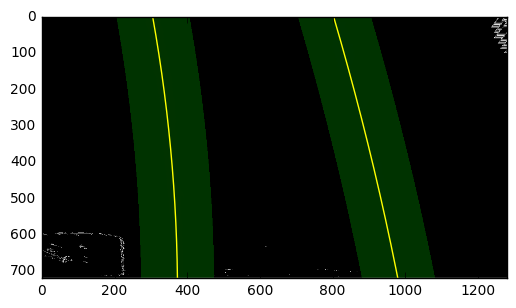

In [114]:

PN.fit_next(_new_bwimg=warped_binary, _new_wimg=warped_orig)
PN.visualize_next()

1415.561m, 2515.448m


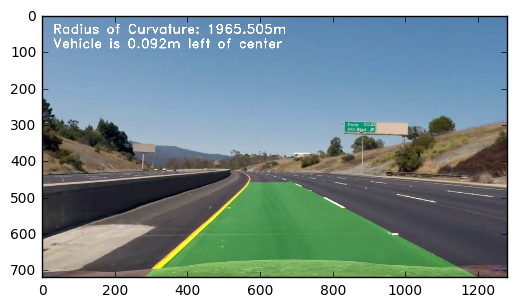

In [115]:
    #------------------------------------------------------------
    # STEP 6. MEASURE CURVATURE AND MAP LANE BACK TO THE REAL-WORLD IMAGE
    #------------------------------------------------------------
    final_img = PN.measureCurvature_and_mapLane(_img=test_img_undist, _Minv=WP.Minv, _save=False)
    if True:
        mpimg.imsave("./vid_images_latest/frame_00021.jpg", final_img)
    

[IDX: 0] Read a new frame:  True
src:  [[  570.           460.        ]
 [  203.33332825   720.        ]
 [ 1166.66662598   720.        ]
 [  730.           460.        ]]
dst:  [[ 320.    0.]
 [ 320.  720.]
 [ 960.  720.]
 [ 960.    0.]]
midpoint:  640
leftx_base: 386
780.369m, 1000.566m
[IDX: 1] Read a new frame:  True
midpoint:  640
leftx_base: 386
734.476m, 558.733m
[IDX: 2] Read a new frame:  True
midpoint:  640
leftx_base: 387
753.377m, 612.325m
[IDX: 3] Read a new frame:  True
midpoint:  640
leftx_base: 370
761.515m, 698.720m
[IDX: 4] Read a new frame:  True
midpoint:  640
leftx_base: 371
789.994m, 796.657m
[IDX: 5] Read a new frame:  True
midpoint:  640
leftx_base: 389
813.611m, 639.031m
[IDX: 6] Read a new frame:  True
midpoint:  640
leftx_base: 390
788.539m, 551.731m
[IDX: 7] Read a new frame:  True
midpoint:  640
leftx_base: 389
814.349m, 600.289m
[IDX: 8] Read a new frame:  True
midpoint:  640
leftx_base: 389
859.935m, 577.785m
[IDX: 9] Read a new frame:  True
midpoint:  64

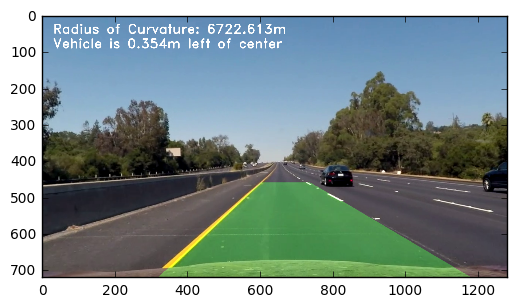

In [116]:
    #------------------------------------------------------------
    # STEP 7. VIDEO PROCESSING
    #------------------------------------------------------------
    #VLD = VideoLaneDetection(DT, "./project_video.mp4")
    VLD = VideoLaneDetection(DT, VIDEO_FILE)
    VLD.run()
    